In [2]:
import numpy as np
import PIL
import matplotlib.pyplot as plt

In [3]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters["b"+str(l)]=np.zeros((layer_dims[l],1))
    return parameters 

In [4]:
def softmax(x):
    ans = np.exp(x)/np.sum(np.exp(x),axis=0)
    return ans
  
def softmax_prime(x):
    ans = softmax(x)*(1-softmax(x))
    return ans
  
def relu(x):
    x = np.maximum(0,x)
    return x

def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [5]:
def linear_forward(A,W,b):
    Z=W.dot(A)+b
    cache = (A, W ,b)
    return Z,cache

In [6]:
def deep_layer(A,W,b,activation):
    Z,linear_cache = linear_forward(A,W,b)
    if activation == 'softmax':
        A = softmax(Z)
        activation_cache = Z
    elif activation == 'relu':
        A = relu(Z)
        activation_cache = Z
    cache = (linear_cache,activation_cache)
    return A,cache

In [7]:
def forward_pass(input_X,parameters):
    caches=[]
    depth = int(len(parameters)/2) # number of layers in the neural network
    A = input_X
    for l in range(1,depth):
        A_prev = A
        A,cache = deep_layer(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],'relu')
        caches.append(cache)
    A_last,cache = deep_layer(A,parameters['W'+str(depth)],parameters['b'+str(depth)],'softmax')
    caches.append(cache)
    return A_last,caches

In [8]:
def compute_cost(AL,Y):  
    Y= np.reshape(Y,(Y.shape[0],Y.shape[1]))
    m = Y.shape[1]
    cost =(-1/m)*(np.multiply(Y,np.log(AL))) #categorical_cross_entropy
    cost = np.squeeze(cost)
    return cost

In [9]:
def linear_backward(dZ,cache):
    A_prev , W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [10]:
def backward_activation(dA, cache, activation):
    linear_cache,activation_cache = cache
    if activation == "relu":
        dZ = dA*relu_prime(activation_cache)
        dA_prev, dW,db = linear_backward(dZ,linear_cache)
    elif activation == "softmax":
        dZ = dA
        dA_prev, dW,db = linear_backward(dZ,linear_cache)
    return dA_prev, dW, db

In [11]:
def backward_pass(A_last,Y,caches):
    grads={}
    L = len(caches)
    m = A_last.shape[1]
    Y = Y.reshape(A_last.shape)
    dA_last_Z = A_last-Y
    current_cache = caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = backward_activation(dA_last_Z,current_cache,activation='softmax')
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_activation(grads['dA'+str(l+1)],current_cache,activation="relu")
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = dW_temp
        grads["db"+str(l+1)]=db_temp
    return grads 

In [12]:
def update_parameters(parameters, grads, learning_rate):
    depth = len(parameters) // 2
    for l in range(depth):
        parameters["W"+str(l+1)] = parameters["W"+ str(l+1)]-learning_rate*grads['dW'+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads['db'+str(l+1)]
    return parameters

In [13]:
def mini_batch_gradient_descent(X,Y,layer_dims=[3,2,1],mini_batch_size=8,epochs=100, learning_rate=0.0075):
  ############## Creating Mini Batches ##########################
    np.random.seed(1)
    m = X.shape[1]
    mini_batches = []
    
    #shuffling the data
    permutation = list(np.random.permutation(X.shape[1]))
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]
    num_of_complete_batches = m // mini_batch_size
    for i in range(num_of_complete_batches):
        mini_batch_X = X_shuffled[:,i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch_Y = Y_shuffled[:,i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    #if there is incomplete batch
    if m % mini_batch_size != 0:
       
        mini_batch_X=X_shuffled[:,num_of_complete_batches*mini_batch_size:num_of_complete_batches*mini_batch_size + (m - mini_batch_size*num_of_complete_batches)]
        mini_batch_Y=Y_shuffled[:,num_of_complete_batches*mini_batch_size:num_of_complete_batches*mini_batch_size + (m - mini_batch_size*num_of_complete_batches)]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    
    ############## Training Model Using Mini Batches ##########################
    #parameters_initialize
    costs=[]
    parameters = initialize_parameters_deep(layer_dims)
    for j in range(epochs):
        for mini_batch in mini_batches:
            x_batch,y_batch=mini_batch
            A_Last,caches = forward_pass(x_batch,parameters)
            cost = np.sum(compute_cost(A_Last, y_batch))/A_Last.shape[0]
            grads = backward_pass(A_Last, y_batch , caches)
            parameters = update_parameters(parameters, grads, learning_rate)
        if j%2 == 0:
            print(f'Iteration {j} : {cost}')
            costs.append(cost)
    return parameters,costs

In [21]:
from scipy.io import loadmat
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist-original.mat', version=1, return_X_y=True)

In [25]:
import numpy as np
from scipy.io import loadmat

# Load the .mat file
data = loadmat('mnist-original.mat')

# Extract features (X) and labels (y)
X = data['data'].T
y = data['label'][0]

# Optionally, you can convert the labels to integers
y = y.astype(int)

# Check the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (70000, 784)
Shape of y: (70000,)


In [26]:
def one_hot(y, depth):
    one_hot_list = np.array([],dtype=int)
    for i in range(depth):
        temp =np.zeros((1,depth),dtype=int)
        temp[0][i]=1
        one_hot_list =np.append(one_hot_list,temp)
    one_hot=np.reshape(one_hot_list,(depth,depth))
    
    y = one_hot[y].T
    return y

In [27]:
train_x = X[0:60000]/255.0 #normalizing the data
train_x=train_x.T
train_y = y[0:60000]
train_y = train_y.astype(int)
train_y= np.reshape(train_y,(1,60000))

test_x = X[60000:X.shape[0]]/255.0 #normalizing the data
test_x=test_x.T
test_y = y[60000:y.shape[0]]
test_y = test_y.astype('int')

In [28]:
train_y = one_hot(train_y,10)

In [29]:
parameters,costs=mini_batch_gradient_descent(train_x, train_y,layer_dims=[784,128,64,32,10],mini_batch_size=64,epochs=40)


Iteration 0 : 0.04399704373619028
Iteration 2 : 0.028438278421380976
Iteration 4 : 0.019168482415652954
Iteration 6 : 0.013614197033708739
Iteration 8 : 0.011685472871079072
Iteration 10 : 0.010247428843990167
Iteration 12 : 0.009574596289092104
Iteration 14 : 0.00914833597685019
Iteration 16 : 0.008264474930857666
Iteration 18 : 0.007056686801925988
Iteration 20 : 0.006094696582698697
Iteration 22 : 0.0050091313987601065
Iteration 24 : 0.004270277287590725
Iteration 26 : 0.00344347180756928
Iteration 28 : 0.0029793538598300077
Iteration 30 : 0.0024694055505456837
Iteration 32 : 0.0022320286426794653
Iteration 34 : 0.0018933667139062575
Iteration 36 : 0.0016463311212377336
Iteration 38 : 0.001360467954631416


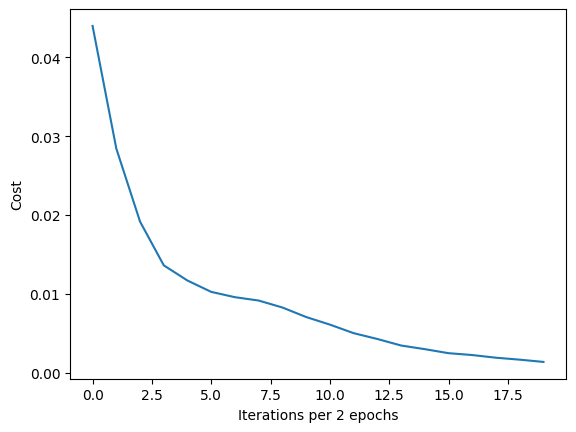

In [30]:
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations per 2 epochs')
plt.show()

In [31]:
correct = 0
incorrect=[]
for i in range(test_y.shape[0]):
    last,_=forward_pass(np.reshape(test_x[:,i],(784,1)),parameters)
    if np.argmax(last) == test_y[i]:
        correct +=1
    else:
        incorrect.append(i)
accuracy = correct/test_y.shape[0]
print("Test Accuracy:",accuracy)

Test Accuracy: 0.971


In [32]:
# Code to convert the image having white background to black
import PIL.ImageOps 
def invert_image(test_img):
    I = np.asarray(test_img)
    zero_pixels=0
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,i] == 0:
                zero_pixels+=1
    non_zero_pixels = 784-zero_pixels
    if non_zero_pixels > zero_pixels:
        inverted_image = PIL.ImageOps.invert(test_img)
        return inverted_image
    else:
        return test_img 

Prediction:  6
Input Image: 


ValueError: Could not save to JPEG for display

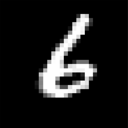

In [55]:
# Try with your own image
from PIL import Image
img = Image.open('test_img.jpg') #path of the image
img_converted = img.convert('L')
img_resized = img_converted.resize((28,28))
img_array=np.asarray(img_resized)/255.0

prediction,_=forward_pass(np.reshape(img_array,(784,1)),parameters)
predicted_num=np.argmax(prediction)
print("Prediction: ",predicted_num)
print("Input Image: ")
img.resize((128,128))